In [49]:
#get the same 'Consolidated_file_sorted.xlsx' where use in cluster prediction python file amd start to build monetory_pbi_final.xlsx file
import pandas as pd
import os

# Read the input file
#consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\2nd_final_output\Consolidated_file.xlsx")
consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\data_files\Consolidated_file_sorted.xlsx')

# Get unique customer names
customer_names = consolidate_df["Customer"].unique()

# Iterate over each customer and create a separate Excel file
for customer in customer_names:
    # Filter the dataframe for the current customer
    #customer_df = consolidate_df[consolidate_df["Customer"] == customer][["RFM_Score", "Customer_segment", "Week", "Cluster","Monetory"]]
    customer_df1 = consolidate_df[consolidate_df["Customer"] == customer][[ "Week","Monetory"]]

    # Create output file name
    output_file_name = f"{customer}.xlsx"
    #output_folder = r"C:/Users/GCV/Documents/MAS/Project AR/con_output/"
    output_folder1 = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_cust_RFM/"
   
    #output_file_path = os.path.join(output_folder, output_file_name)
    output_file_path1 = os.path.join(output_folder1, output_file_name)

    #print(output_folder)
    #print(output_file_name)
    #print(output_file_path)

    # Save the filtered dataframe to a separate Excel file
    #customer_df.to_excel(output_file_path, index=False)
    
    
    #Remove customers who has low data points(when customer has low datapoints ES model occurs some errors)
    row_count  = customer_df1.shape[0]
    if row_count >20:
        customer_df1.to_excel(output_file_path1, index=False)


In [50]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from openpyxl import Workbook as wb
from itertools import cycle

import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns 
import matplotlib.pyplot as plt
import openpyxl

In [51]:
#put model into future_prediction function
def future_prediction(filename):
    # Load the input data from the excel file

    # Perform the time series modeling here

    %matplotlib inline 
    plt.style.use('bmh')
    sns.set_style("whitegrid")
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    warnings.filterwarnings("ignore")
    color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    #calculate smape
    def smape(a,f):
        return 1/len(a)*np.sum(2 * np.abs(f - a) / (np.abs(a)+ np.abs(f))*100)
    
    #read the file
    rfm_data=pd.read_excel(filename)
    rfm_data.head()
    #split data into train and test
    row_count  = rfm_data.shape[0]

    train_data = rfm_data.iloc[:(row_count-8)]
    test_data = rfm_data.iloc[(row_count-8):] 
    
    
    #print(train_data)
    #getting predicting values
    span = 12
    alpha = 2/(span+1)

    simpleExpSmooth_model = SimpleExpSmoothing(train_data['Monetory']).fit(smoothing_level=alpha,optimized=True)
    doubleExpSmooth_model = ExponentialSmoothing(train_data['Monetory'],trend='add',seasonal_periods=6).fit()
    tripleExpSmooth_model = ExponentialSmoothing(train_data['Monetory'],trend='add',damped_trend=True,seasonal='add',seasonal_periods=6).fit()

    predictions_simpleExpSmooth_model = simpleExpSmooth_model.forecast(6)
    predictions_doubleExpSmooth_model = doubleExpSmooth_model.forecast(6)
    predictions_tripleExpSmooth_model = tripleExpSmooth_model.forecast(6)
    #print(predictions_tripleExpSmooth_model ,predictions_simpleExpSmooth_model , predictions_doubleExpSmooth_model )
    
    
    #calculate smape
    smape_simple = smape(test_data["Monetory"] ,predictions_tripleExpSmooth_model)
    smape_double = smape(test_data["Monetory"] ,predictions_doubleExpSmooth_model)
    smape_triple = smape(test_data["Monetory"] ,predictions_tripleExpSmooth_model)
    
    # print('Simple Exponential Smoothing sMAPE:'  ," = ", smape(test_data["RFM_Score"],predictions_simpleExpSmooth_model))
    # print('Double Exponential Smoothing sMAPE:' ," = ", smape(test_data["RFM_Score"],predictions_doubleExpSmooth_model))
    # print('Triple Exponential Smoothing sMAPE:' ," = ", smape(test_data["RFM_Score"],predictions_tripleExpSmooth_model))

    
    train_data['Monetory'].plot(legend=True,label='TRAIN')
    test_data['Monetory'].plot(legend=True,label='TEST',figsize=(15,6))
    predictions_simpleExpSmooth_model.plot(legend=True,label='Simple Exponential Forecast')
    predictions_doubleExpSmooth_model.plot(legend=True,label='Double Exponential Forecast')
    predictions_tripleExpSmooth_model.plot(legend=True,label='Triple Exponential Forecast')


    model = tripleExpSmooth_model = ExponentialSmoothing(train_data['Monetory'],trend='add',damped_trend=True,seasonal='add',seasonal_periods=6).fit()
    fcast_simple = simpleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+ 3).rename('Simple Exponential Forecast')
    fcast_double = doubleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+3).rename('Double Exponential Forecast')
    fcast_triple = tripleExpSmooth_model.predict(len(rfm_data),len(rfm_data)+3).rename('Triple Exponential Forecast')

    #df = fcast.to_frame()
    #df.columns = ['future_pred']

    # print(filename ," Predicted Future Values are "  , fcast_simple)
    # print(filename, " sMAPE is " , smape_triple)
    # print(filename," Predicted Values are " , predictions_tripleExpSmooth_model)

    new_data = {'Customer Name': [filename], 'Predicted Values': [predictions_tripleExpSmooth_model] ,'Future Predictions Simple ES': [fcast_simple] , 'Future Predictions Double ES': [fcast_double], 'Future Predictions Triple ES': [fcast_double], 'sMAPE Simple ES':[smape_simple], 'sMAPE Double ES':[smape_double], 'sMAPE Triple ES':[smape_triple]}  
  
    # Create DataFrame  
    final_data = pd.DataFrame(new_data)  
    
    # Print the output.   
    #final_data.to_csv(f"drive/MyDrive/Colab Notebooks/Data/AR Clusters/AR Outputs/{filename}")
        

    return final_data  


prediction part done


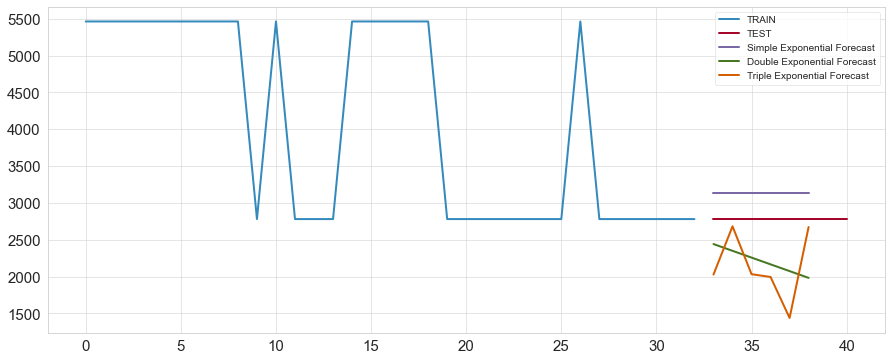

In [52]:
import os
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_cust_RFM/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_cust_prediction/"

for filename in os.listdir(input_folder):
    if filename.endswith(".xlsx"):
        #print(filename)
        file_path = os.path.join(input_folder, filename)

        final_data = future_prediction(file_path)

        
        final_data.to_excel(os.path.join(output_folder, filename))

        #print(file_path)
        #print(final_data)
print("prediction part done")

In [53]:

#creating dashboard back end excel file(adding 2022(rfm,cluster,segmentation) and 2023(rfm,cluster,segmentation) columns)

import pandas as pd
import warnings
warnings.simplefilter("ignore")


# read in the data from an Excel file
df = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/data_files/Consolidated_file_sorted.xlsx")
# extract week numbers as integers
df['Week_num'] = df['Week'].str.extract(r'(\d+)').astype(int)

# identify weeks in 2022 and 2023
week_22 = [str(w).zfill(2) for w in range(16, 52)]
week_23 = [str(w).zfill(2) for w in range(1, 16)] + [str(w).zfill(2) for w in range(52, 53)]

# subset the data to include only weeks in 2022 and 2023
df_2022 = df[df['Week_num'].isin(range(16, 52))]
df_2023 = df[df['Week_num'].isin(range(1, 16)) | df['Week_num'].isin([52])] #alert on this is somewhat hard coding part

# create new columns for 2022 and 2023 weeks
df_2022['2022 Week'] = df_2022['Week']
df_2023['2023 Week'] = df_2023['Week']

# concatenate the two subsets back into the original DataFrame
df = pd.concat([df_2022, df_2023], ignore_index=True)



# Create new columns with empty values
df['Monetary_2022'] = ''
# df['Customer_segment_2022'] = ''
# df['Cluster_2022'] = ''



# Create a boolean mask for the rows where "2022 Week" is not null
mask = ~df['2022 Week'].isnull()

# Assign the values to the new columns using the mask
df.loc[mask, 'Monetary_2022'] = df.loc[mask, 'Monetory']
# df.loc[mask, 'Customer_segment_2022'] = df.loc[mask, 'Customer_segment']
# df.loc[mask, 'Cluster_2022'] = df.loc[mask, 'Cluster']



df['Monetary_2023'] = ''
# df['Customer_segment_2023'] = ''
# df['Cluster_2023'] = ''



# Create a boolean mask for the rows where "2022 Week" is not null
mask = ~df['2023 Week'].isnull()

# Assign the values to the new columns using the mask
df.loc[mask, 'Monetary_2023'] = df.loc[mask, 'Monetory']
# df.loc[mask, 'Customer_segment_2023'] = df.loc[mask, 'Customer_segment']
# df.loc[mask, 'Cluster_2023'] = df.loc[mask, 'Cluster']

df = df.drop(columns=['Unnamed: 0', 'RFM_Score', 'Customer_segment','Cluster'])



# # print the result
# print(df.head())
# print(df.tail())
print(df.columns)
# save the result to a new Excel file
df.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/data_files/Monetory_Actual_values.xlsx", index=False)


Index(['Customer', 'Week', 'Monetory', 'Week_num', '2022 Week', '2023 Week',
       'Monetary_2022', 'Monetary_2023'],
      dtype='object')


In [54]:
#split multivalues in cells to columns

import os
import glob
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt


def process_input_file(file_path):
    # read the input file as a DataFrame with temporary header names
    df = pd.read_excel(file_path, header=0)
    df1= df[['Predicted Values', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']]
    df1 = df1.fillna('')
    df_sMAPE =df[['sMAPE Simple ES','sMAPE Double ES','sMAPE Triple ES']]
    # set temporary header names
    temp_header = ["Column" + str(i) for i in range(df1.shape[1])]
    df1.columns = temp_header
    
    new_df = pd.DataFrame()
    
    for col in df1.columns:
        # split the 'Actual Values' column into separate columns
        df_actual = df1[col].str.split('\n', expand=True)
        df_actual = df_actual.transpose()
        df_actual = df_actual.drop(index=(df_actual.shape[0]-1))
        
        new_df = pd.concat([new_df, df_actual], axis=1, ignore_index=False)
    
    # reset header names to None
    #new_df.columns = None
    new_df.columns = ['Predicted Values', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']

    # reset index
    new_df = new_df.reset_index(drop=True)
    #split multi line text in single values to separate columns
    new_df = new_df.apply(lambda x: x.str.split())

    # extract the second value from each cell in all columns(ex- 33 2.321 to 2.321)
    new_df = new_df.apply(lambda x: x.str[1])
    
    #file_name = os.path.basename(file_path)
    file_name, file_extension = os.path.splitext(os.path.basename(file_path))

    #file_name = file_path.split('.')[0]
    # create a new column with the file name
    new_df['customer'] = file_name

    
    
    final_df = pd.concat([new_df, df_sMAPE], axis=1, ignore_index=False)
    final_df = final_df[['customer','Predicted Values', 'Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES','sMAPE Simple ES', 'sMAPE Double ES', 'sMAPE Triple ES']]
    final_df = final_df.fillna(0)
    
    #selecting minimum sMAPE and get best predicted values
    pred_cols  = final_df[['Future Predictions Simple ES','Future Predictions Double ES', 'Future Predictions Triple ES']]
    sMAPE_cols = final_df[['sMAPE Simple ES', 'sMAPE Double ES', 'sMAPE Triple ES']]
   
    #sort cloumn names in sMAPEs
    sorted_columns = sMAPE_cols.mean().sort_values().index.tolist()
    
    
    # create an empty list to store the column names
    dup_col = []

    # iterate over the columns
    for col in pred_cols.columns:
        # check if all values in the column are duplicates
        if pred_cols[col].duplicated().all():
            # add the column name to the list
            dup_col.append(col)
    
       
        for i, col in enumerate(sorted_columns):
            
            if col == 'sMAPE Triple ES':
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Triple ES'
            elif col == 'sMAPE Double ES':
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Double ES'
            else:
                if col in dup_col:
                    break
                else:
                    best_col = 'Future Predictions Simple ES'

                    
    final_df['best predict'] = final_df[best_col]  
    smape =  sMAPE_cols[sorted_columns[0]]
    final_df['sMAPE'] = smape
    return final_df

In [55]:
#save each dfs in related folder
input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_cust_prediction/"
output_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_cust_prediction_data/"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)

# Loop through each file name and process the corresponding Excel file
for file_name in file_names:
    final_data = process_input_file(file_name)
    #final_data2 = add_week_column(file_name)
   
    #final_data = pd.concat([final_data2,final_data1], axis=1).reset_index(drop=True)
    
    
    output_file_name = os.path.join(output_folder, os.path.basename(file_name))
    output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
    final_data.to_excel(output_file_name, index = False)    
    
    
print("done")

done


In [56]:
#make data frames related to each customer with prediction ,smape,...

import pandas as pd
import numpy as np

input_folder = "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_cust_prediction_data/"
output_folder= "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_cust_final_df/"

# Set the file pattern want to match

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)

#print(file_names)
for file in file_names:
    df = pd.read_excel(file)

    df_con = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/data_files/Monetory_Actual_values.xlsx")


    first_value = df_con['Week_num'].iloc[1]
    last_value = df_con['Week_num'].iloc[-1]

    # calculate the starting week number
    starting_week = last_value -6 + 52
   

    # define the range of values to repeat
    start_val = 1
    end_val = 51
    repeat_val = starting_week

    # calculate the number of times to repeat the range
    num_rows =  len(df.index)
    num_repeats = int(np.ceil(num_rows / (end_val - start_val + 1)))

    # create the array of values to repeat
    vals_to_repeat = np.concatenate((np.arange(start_val, end_val+1),np.arange(repeat_val, end_val+1)))

    # repeat the array the necessary number of times
    repeated_vals = np.tile(vals_to_repeat, num_repeats)[:num_rows]
    # add the repeated values to the new column in the dataframe
    week_vals = [(starting_week + i) % 51 or 51 for i in range(num_rows)]
    df.insert(loc=0, column='Week', value=week_vals)
    last_w = df['Week'].iloc[-1]
    list_week = []
    for i in range (4):
        list_week.append(last_w + i+1)

    df_w = pd.DataFrame({'Week': list_week})
     
    df = pd.concat([df,df_w], axis =0).reset_index(drop = True)
    df['Week num'] = 'W' + df['Week'].astype(str)
    
    
    customer_name = df['customer'].iloc[1]

    # Replace the missing values in the "customer" column with the customer name
    df['customer'] = df['customer'].fillna(customer_name)
    # print(customer_name)
    # print(df)
    
    df['Future_prediction'] = ''
    df.loc[6:, 'Future_prediction'] = df.loc[:3, 'best predict'].values
    
    df['sMAPE'].fillna(df['sMAPE'][0], inplace=True)
    
    df = df.fillna(0)
    output_file_name = os.path.join(output_folder, os.path.basename(file))
    output_file_name = os.path.splitext(output_file_name)[0] + ".xlsx"
    
    
    df.to_excel(output_file_name, index = False)   
    
    
print("done")

done


In [57]:
#merge all customer vise prediction files into one file

import pandas as pd

input_folder =  "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_cust_final_df/"
output_file = "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_merged_predictions.xlsx"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)


# create empty dataframe to store merged data
merged_df = pd.DataFrame()

# loop through customer files and merge data
for filename in file_names:   # replace file_list with the list of file names in your folder
    df = pd.read_excel(filename)   # read in each file as a data frame
    merged_df = pd.concat([merged_df, df], ignore_index=True)   # append each data frame to the merged data frame

    
    
merged_df['Week'] , merged_df['Week num'] = merged_df['Week num'], merged_df['Week']
# print the merged data frame
print(merged_df.columns)


# drop rows with negative values in "future_prediction" column
merged_df = merged_df.drop(merged_df[merged_df['Future_prediction'] < 0].index)

merged_df.to_excel(output_file)
print("done")

Index(['Week', 'customer', 'Predicted Values', 'Future Predictions Simple ES',
       'Future Predictions Double ES', 'Future Predictions Triple ES',
       'sMAPE Simple ES', 'sMAPE Double ES', 'sMAPE Triple ES', 'best predict',
       'sMAPE', 'Week num', 'Future_prediction'],
      dtype='object')
done


In [58]:
#getting filter values based on weeek number in predictions
import pandas as pd

df = pd.read_excel("C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_merged_predictions.xlsx")
#df.head()

df_con = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/data_files/Monetory_Actual_values.xlsx")


first_value = df_con['Week_num'].iloc[1]
last_value = df_con['Week_num'].iloc[-1]

# calculate the starting week number
starting_week = last_value -6 + 52


start_val = 1
end_val = 51
repeat_val = starting_week

# calculate the number of times to repeat the range
num_rows =  len(df.index)
num_repeats = int(np.ceil(num_rows / (end_val - start_val + 1)))

# create the array of values to repeat
vals_to_repeat = np.concatenate((np.arange(start_val, end_val+1),np.arange(repeat_val, end_val+1)))

# repeat the array the necessary number of times
repeated_vals = np.tile(vals_to_repeat, num_repeats)[:num_rows]
# add the repeated values to the new column in the dataframe
week_vals = [(starting_week + i) % 51 or 51 for i in range(num_rows)]

pred_starting_week = (starting_week+6) % 51

print(pred_starting_week)
week_filter = [0]*4
for i in range(4):
    week_filter[i]= pred_starting_week +i

    
#print(week_filter)

# create an empty list to store the filtered DataFrames
df_list = []

# loop over each value in week_list and filter the DataFrame
for week in week_filter:
    df_filtered = df[df['Week num'] == week]
    df_list.append(df_filtered)

# concatenate all the DataFrames in df_list into one DataFrame
df_combined = pd.concat(df_list)


# convert Future_prediction column to float
df_combined['Future_prediction'] = df_combined['Future_prediction'].astype(float)
    

# # apply the function to create a new column
# df_combined['Predicted_Customer_Segmentation'] = df_combined['Future_prediction'].apply(map_to_segment)
# df_combined['Predicted_Customer_Cluster'] = df_combined['Future_prediction'].apply(map_to_cluster)

df_to_actual = df_combined[['Week', 'customer','Week num', 'Future_prediction','sMAPE']]


print(df_to_actual)

df_to_actual.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_prediction_values_merge.xlsx", index=False)


6
    Week                             customer  Week num  Future_prediction  \
6     W6      Abercrombie & Fitch Trading Co.         6       3.492217e+05   
16    W6                                Aerie         6       1.098010e+06   
26    W6     AMAZON ESSENTIAL - SPOTTED ZEBRA         6       2.071943e+04   
36    W6                            Amazon UK         6       7.780175e+04   
46    W6       AMERICAN DESIGNER FASHION, S.A         6       6.368311e+03   
..   ...                                  ...       ...                ...   
162   W9  Kimberly-Clark Australia Pty. Limit         9       1.603127e+05   
196   W9                     prAna Living LLC         9       3.080382e+06   
206   W9                    Puritas (Pvt) Ltd         9       1.335678e+03   
229   W9                     Summersalt, Inc.         9       5.685843e+06   
239   W9      The Colombo Fashion WSwim Pvt L         9       1.431960e+03   

         sMAPE  
6    30.348095  
16   15.461519  
26    4.73

In [59]:
#concat Actual and prediction data frames in to one df

In [60]:
import pandas as pd 
import numpy as np

df_actual = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/data_files/Monetory_Actual_values.xlsx")
df_predict = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_prediction_values_merge.xlsx")
#df_reference =  pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/Nature.xlsx")


df_actual['Future_prediction'] = ''
df_actual['sMAPE'] = ''

# df_actual['Predicted_Customer_Segmentation'] = ''
# df_actual['Predicted_Customer_Cluster'] = ''

# #chechk always if Unnamed: 0 column exists if its availble drop it(if it availble its harder to concat dfs)
# if 'Unnamed: 0' in df.columns:
#     df_actual.drop(columns=['Unnamed: 0'], inplace=True)

df_predict.rename(columns={'customer': 'Customer'}, inplace=True)
df_predict.rename(columns={'Week num': 'Week_num'}, inplace=True)


# ['Customer', 'Week', 'Monetory', 'Week_num', '2022 Week', '2023 Week','Monetary_2022', 'Monetary_2023'],

# Index(['Week', 'customer', 'Week num', 'Future_prediction', 'sMAPE'], dtype='object')



# creating null column because of concat
df_predict[['Monetory', '2022 Week', '2023 Week', 'Monetary_2022', 'Monetary_2023']] = None

print(df_actual.columns)
print(df_predict.columns)


#common_cols = list(set(df_actual.columns) & set(df_predict.columns))
df_actual = pd.concat([df_actual, df_predict], axis=0).reset_index()


#df_merged = pd.merge(df_actual, df_reference, on='Customer', how='left')

df_actual.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_pbi_file_1.xlsx")

Index(['Customer', 'Week', 'Monetory', 'Week_num', '2022 Week', '2023 Week',
       'Monetary_2022', 'Monetary_2023', 'Future_prediction', 'sMAPE'],
      dtype='object')
Index(['Week', 'Customer', 'Week_num', 'Future_prediction', 'sMAPE',
       'Monetory', '2022 Week', '2023 Week', 'Monetary_2022', 'Monetary_2023'],
      dtype='object')


In [61]:
#filter each cusromer and get all data in single data frame 

#consolidate_df = pd.read_excel(r'C:\Users\GCV\Documents\MAS\Project AR\Testing\data_files\Consolidated_file_sorted.xlsx')
import pandas as pd
import os

consolidate_df = pd.read_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_pbi_file_1.xlsx")

# Get unique customer names
customer_names = consolidate_df["Customer"].unique()
#print(customer_names)

dfs = []
# Iterate over each customer and create a separate Excel file
for customer in customer_names:
    # Filter the dataframe for the current customer
    #customer_df = consolidate_df[consolidate_df["Customer"] == customer][["RFM_Score", "Customer_segment", "Week", "Cluster","Monetory"]]
    customer_df1 = consolidate_df[consolidate_df["Customer"] == customer][["Customer", "Week","Monetory","Week_num","2022 Week","2023 Week","Monetary_2022","Monetary_2023","Future_prediction","sMAPE"]]
    
    
    #add Week column which include W1 to W51 
    weeks = ['W'+str(i) for i in range(1,52)]
    oder =  [i for i in range(1,52)]
    customer = customer_df1["Customer"].iloc[1]
    # create a dictionary with the column names and values
    data = {'Customer': [str(customer)]*51, 'Week': weeks,'Oder':oder}

    # create a dataframe from the dictionary
    customer_df2 = pd.DataFrame(data)
    # print(customer_df2.tail())
    # print(customer_df1.tail())

    full_join_df = pd.merge(customer_df2,customer_df1, on ="Week", how ="outer")
    
    #print(full_join_df.head())
    
    
    
    # Create output file name
    output_file_name = f"{customer}.xlsx"
    #output_folder = r"C:/Users/GCV/Documents/MAS/Project AR/con_output/"
    output_folder1 = r"C:/Users/GCV/Documents/MAS/Project AR/Testing/test/"
   
    #output_file_path = os.path.join(output_folder, output_file_name)
    output_file_path1 = os.path.join(output_folder1, output_file_name)
    full_join_df = full_join_df.drop('Customer_y', axis = 1)
    dfs.append(full_join_df)

    full_join_df.to_excel(output_file_path1, index=False)



In [63]:
#getting final output excel file

import pandas as pd
import os
import glob

input_folder =  "C:/Users/GCV/Documents/MAS/Project AR/Testing/test/"
output_file = "C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_merged_predictions.xlsx"

# Set the file pattern you want to match, for example, all files with ".txt" extension

file_pattern= input_folder + "*.xlsx"

# Use glob function to get the file names that match each file pattern
file_names = glob.glob(file_pattern)


# create empty dataframe to store merged data
merged_df = pd.DataFrame()

# loop through customer files and merge data
for filename in file_names:   # replace file_list with the list of file names in your folder
    df = pd.read_excel(filename)   # read in each file as a data frame

    merged_df = pd.concat([merged_df, df], ignore_index=True)   # append each data frame to the merged data frame
    

merged_df = merged_df.drop('Monetory',axis =1)

#merged_df = merged_df.fillna(0)
merged_df = merged_df.drop(['Unnamed: 0.1','Unnamed: 0','index','Customer'], axis=1)
merged_df = merged_df.rename(columns={'Customer_x': 'Customer'})



#make oder for each week to sort power bi dashboard
week_order = {'W1': 1, 'W2': 2, 'W3': 3, 'W4': 4, 'W5': 5, 'W6': 6, 'W7': 7, 'W8': 8, 'W9': 9, 'W10': 10, 'W11': 11, 'W12': 12, 'W13': 13, 'W14': 14, 'W15': 15, 'W16': 16, 'W17': 17, 'W18': 18, 'W19': 19, 'W20': 20, 'W21': 21, 'W22': 22, 'W23': 23, 'W24': 24, 'W25': 25, 'W26': 26, 'W27': 27, 'W28': 28, 'W29': 29, 'W30': 30, 'W31': 31, 'W32': 32, 'W33': 33, 'W34': 34, 'W35': 35, 'W36': 36, 'W37': 37, 'W38': 38, 'W39': 39, 'W40': 40, 'W41': 41, 'W42': 42, 'W43': 43, 'W44': 44, 'W45': 45, 'W46': 46, 'W47': 47, 'W48': 48, 'W49': 49, 'W50': 50, 'W51': 51, 'W52': 52}

merged_df['week_order'] = merged_df['Week'].map(week_order)
#merged_df = merged_df.sort_values('week_order')

#merged_df.to_excel(output_file)
merged_df.to_excel(r"C:/Users/GCV/Documents/MAS/Project AR/Testing/monetory_pbi_file_final.xlsx")
print("done")
print(merged_df.head())

done
                             Customer Week  Oder  Week_num 2022 Week  \
0     Abercrombie & Fitch Trading Co.   W1   1.0       1.0       NaN   
2807                              NaN   W1   NaN       1.0       NaN   
2809                              NaN   W1   NaN       1.0       NaN   
2810                              NaN   W1   NaN       1.0       NaN   
2811                              NaN   W1   NaN       1.0       NaN   

     2023 Week  Monetary_2022  Monetary_2023  Future_prediction  sMAPE  \
0           W1            NaN      362213.62                NaN    NaN   
2807        W1            NaN      450100.83                NaN    NaN   
2809        W1            NaN       43303.53                NaN    NaN   
2810        W1            NaN     4441203.89                NaN    NaN   
2811        W1            NaN        2781.20                NaN    NaN   

      week_order  
0              1  
2807           1  
2809           1  
2810           1  
2811           1  
